Copyright (c) 2021 Björn Ottosson

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies
of the Software, and to permit persons to whom the Software is furnished to do
so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

**Overview**

This notebook was used to compute coefficients for the compute_max_saturation function in this blog post: http:#bottosson.github.io/posts/gamutclipping/

The code is available for reference, since it could be useful to derive coefficients for other color spaces. It was written quickly to derive the values and both structure and documentation is poor.

In [36]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def linear_srgb_to_oklab(c):
    l = 0.4122214708 * c[0,...] + 0.5363325363 * c[1,...] + 0.0514459929 * c[2,...];
    m = 0.2119034982 * c[0,...] + 0.6806995451 * c[1,...] + 0.1073969566 * c[2,...];
    s = 0.0883024619 * c[0,...] + 0.2817188376 * c[1,...] + 0.6299787005 * c[2,...];

    l_ = np.cbrt(l);
    m_ = np.cbrt(m);
    s_ = np.cbrt(s);

    return np.array([
        0.2104542553*l_ + 0.7936177850*m_ - 0.0040720468*s_,
        1.9779984951*l_ - 2.4285922050*m_ + 0.4505937099*s_,
        0.0259040371*l_ + 0.7827717662*m_ - 0.8086757660*s_,
    ])

# RGB oklab_to_linear_srgb(Lab c)
# {
#     # this is the inverse of M2 (Lab to l'm's') conversion matrix on wikipedia
#     float l_ = c.L + 0.3963377774f * c.a + 0.2158037573f * c.b;  # M2_1 00 01 02
#     float m_ = c.L - 0.1055613458f * c.a - 0.0638541728f * c.b;  # M2_1 10 11 12
#     float s_ = c.L - 0.0894841775f * c.a - 1.2914855480f * c.b;  # M2_1 20 21 22

#     float l = l_ * l_ * l_;
#     float m = m_ * m_ * m_;
#     float s = s_ * s_ * s_;

#     # this is the inverse of the linear sRGB to lms conversion matrix on wikipedia
#     return {
#         +4.0767416621f * l - 3.3077115913f * m + 0.2309699292f * s, # lms_sRGB 00 01 02
#         -1.2684380046f * l + 2.6097574011f * m - 0.3413193965f * s, # lms_sRGB 10 11 12
#         -0.0041960863f * l - 0.7034186147f * m + 1.7076147010f * s, # lms_sRGB 20 21 22
#     };
# }


# define functions for R, G and B as functions of S,h (with L = 1 and S = C/L)

# def to_lms(S,h):
#   a = S*np.cos(h)
#   b = S*np.sin(h)

#   l_ = 1 + 0.3963377774 * a + 0.2158037573 * b; # M2_1 _ 01 02
#   m_ = 1 - 0.1055613458 * a - 0.0638541728 * b; # M2_1 _ 11 12
#   s_ = 1 - 0.0894841775 * a - 1.2914855480 * b; # M2_1 _ 21 22

#   l = l_*l_*l_;
#   m = m_*m_*m_;
#   s = s_*s_*s_;

#   return (l,m,s)

# def to_lms_dS(S,h):
#   a = S*np.cos(h)
#   b = S*np.sin(h)

#   l_ = 1 + 0.3963377774 * a + 0.2158037573 * b; # M2_1 _ 01 02
#   m_ = 1 - 0.1055613458 * a - 0.0638541728 * b; # M2_1 _ 11 12
#   s_ = 1 - 0.0894841775 * a - 1.2914855480 * b; # M2_1 _ 21 22

#   l = (0.3963377774*np.cos(h) + 0.2158037573*np.sin(h))*3*l_*l_;  # M2_1 _ 01 02
#   m = (-0.1055613458*np.cos(h) - 0.0638541728*np.sin(h))*3*m_*m_; # M2_1 _ 11 12
#   s = (-0.0894841775*np.cos(h) - 1.2914855480*np.sin(h))*3*s_*s_; # M2_1 _ 21 22

#   return (l,m,s)

# def to_lms_dS2(S,h):
#   a = S*np.cos(h)
#   b = S*np.sin(h)

#   l_ = 1 + 0.3963377774 * a + 0.2158037573 * b; # M2_1 _ 01 02
#   m_ = 1 - 0.1055613458 * a - 0.0638541728 * b; # M2_1 _ 11 12
#   s_ = 1 - 0.0894841775 * a - 1.2914855480 * b; # M2_1 _ 21 22

#   l = (0.3963377774*np.cos(h) + 0.2158037573*np.sin(h))**2*6*l_; # M2_1 _ 01 02
#   m = (-0.1055613458*np.cos(h) - 0.0638541728*np.sin(h))**2*6*m_; # M2_1 _ 01 02
#   s = (-0.0894841775*np.cos(h) - 1.2914855480*np.sin(h))**2*6*s_; # M2_1 _ 01 02

#   return (l,m,s)


# def to_R(S,h):
#   (l,m,s) = to_lms(S,h)
#   return 4.0767416621*l - 3.3077115913*m + 0.2309699292*s  # lms_sRGB 00 01 02

# def to_R_dS(S,h):
#   (l,m,s) = to_lms_dS(S,h)
#   return 4.0767416621*l - 3.3077115913*m + 0.2309699292*s  # lms_sRGB 00 01 02

# def to_R_dS2(S,h):
#   (l,m,s) = to_lms_dS2(S,h)
#   return 4.0767416621*l - 3.3077115913*m + 0.2309699292*s  # lms_sRGB 00 01 02

# def to_G(S,h):
#   (l,m,s) = to_lms(S,h)
#   return -1.2681437731*l + 2.6097574011*m - 0.3413193965*s  # lms_sRGB 10 11 12

# def to_G_dS(S,h):
#   (l,m,s) = to_lms_dS(S,h)
#   return -1.2681437731*l + 2.6097574011*m - 0.3413193965*s  # lms_sRGB 10 11 12

# def to_G_dS2(S,h):
#   (l,m,s) = to_lms_dS2(S,h)
#   return -1.2681437731*l + 2.6097574011*m - 0.3413193965*s  # lms_sRGB 10 11 12

# def to_B(S,h):
#   (l,m,s) = to_lms(S,h)
#   return -0.0041960863*l - 0.7034186147*m + 1.7076147010*s  # lms_sRGB 20 21 22

# def to_B_dS(S,h):
#   (l,m,s) = to_lms_dS(S,h)
#   return -0.0041960863*l - 0.7034186147*m + 1.7076147010*s  # lms_sRGB 20 21 22

# def to_B_dS2(S,h):
#   (l,m,s) = to_lms_dS2(S,h)
#   return -0.0041960863*l - 0.7034186147*m + 1.7076147010*s  # lms_sRGB 20 21 22


above but in rec2020

In [38]:
# vec3 rec2020_to_oklab(vec3 rgb)
# {
#   mat3 M = mat3( # M1 * rgb_to_xyz
#       0.61668844, 0.2651402 , 0.10015065,
#       0.36015907, 0.63585648, 0.20400432,
#       0.02304329, 0.09903023, 0.69632468);
#   vec3 lms = M * rgb;
#   lms = pow(max(vec3(0.0), lms), vec3(1.0/3.0));
#   mat3 M2 = mat3(
#       0.21045426,  1.9779985 ,  0.02590404,
#       0.79361779, -2.42859221,  0.78277177,
#      -0.00407205,  0.45059371, -0.80867577);
#   return M2 * lms;
# }

def rec2020_to_oklab(c):
    l = 0.61668844 * c[0,...] + 0.36015907 * c[1,...] + 0.02304329 * c[2,...];
    m = 0.2651402 * c[0,...] + 0.63585648 * c[1,...] + 0.09903023 * c[2,...];
    s = 0.10015065 * c[0,...] + 0.20400432 * c[1,...] + 0.69632468 * c[2,...];

    l_ = np.cbrt(l);
    m_ = np.cbrt(m);
    s_ = np.cbrt(s);

    return np.array([
        0.2104542553*l_ + 0.7936177850*m_ - 0.0040720468*s_,
        1.9779984951*l_ - 2.4285922050*m_ + 0.4505937099*s_,
        0.0259040371*l_ + 0.7827717662*m_ - 0.8086757660*s_,
    ])


# vec3 oklab_to_rec2020(vec3 oklab)
# {
#   mat3 M2inv = mat3(
#       1.        ,  1.00000001,  1.00000005,
#       0.39633779, -0.10556134, -0.08948418,
#       0.21580376, -0.06385417, -1.29148554);
#   vec3 lms = M2inv * oklab;
#   lms = lms*lms*lms;
#   mat3 M = mat3( # = xyz_to_rec2020 * M1inv
#       2.14014041, -0.88483245, -0.04857906,
#      -1.24635595,  2.16317272, -0.45449091,
#       0.10643173, -0.27836159,  1.50235629);
#   return M * lms;
# }

# 2.14014041   -1.24635595   0.10643173 # lms_rec2020 00 01 02
# -0.88483245   2.16317272  -0.27836159 # lms_rec2020 10 11 12
# -0.04857906  -0.45449091   1.50235629 # lms_rec2020 20 21 22

# define functions for R, G and B as functions of S,h (with L = 1 and S = C/L)

def to_lms(S,h):
  a = S*np.cos(h)
  b = S*np.sin(h)

  l_ = 1 + 0.3963377774 * a + 0.2158037573 * b;
  m_ = 1 - 0.1055613458 * a - 0.0638541728 * b;
  s_ = 1 - 0.0894841775 * a - 1.2914855480 * b;

  l = l_*l_*l_;
  m = m_*m_*m_;
  s = s_*s_*s_;

  return (l,m,s)

def to_lms_dS(S,h):
  a = S*np.cos(h)
  b = S*np.sin(h)

  l_ = 1 + 0.3963377774 * a + 0.2158037573 * b;
  m_ = 1 - 0.1055613458 * a - 0.0638541728 * b;
  s_ = 1 - 0.0894841775 * a - 1.2914855480 * b;

  l = (0.3963377774*np.cos(h) + 0.2158037573*np.sin(h))*3*l_*l_;
  m = (-0.1055613458*np.cos(h) - 0.0638541728*np.sin(h))*3*m_*m_;
  s = (-0.0894841775*np.cos(h) - 1.2914855480*np.sin(h))*3*s_*s_;

  return (l,m,s)

def to_lms_dS2(S,h):
  a = S*np.cos(h)
  b = S*np.sin(h)

  l_ = 1 + 0.3963377774 * a + 0.2158037573 * b;
  m_ = 1 - 0.1055613458 * a - 0.0638541728 * b;
  s_ = 1 - 0.0894841775 * a - 1.2914855480 * b;

  l = (0.3963377774*np.cos(h) + 0.2158037573*np.sin(h))**2*6*l_;
  m = (-0.1055613458*np.cos(h) - 0.0638541728*np.sin(h))**2*6*m_;
  s = (-0.0894841775*np.cos(h) - 1.2914855480*np.sin(h))**2*6*s_;

  return (l,m,s)


def to_R(S,h):
  (l,m,s) = to_lms(S,h)
  return 2.14014041*l - 1.24635595*m + 0.10643173*s  # lms_rec2020 00 01 02

def to_R_dS(S,h):
  (l,m,s) = to_lms_dS(S,h)
  return 2.14014041*l - 1.24635595*m + 0.10643173*s  # lms_rec2020 00 01 02

def to_R_dS2(S,h):
  (l,m,s) = to_lms_dS2(S,h)
  return 2.14014041*l - 1.24635595*m + 0.10643173*s  # lms_rec2020 00 01 02

def to_G(S,h):
  (l,m,s) = to_lms(S,h)
  return -0.88483245*l + 2.16317272*m - 0.27836159*s  # lms_rec2020 10 11 12

def to_G_dS(S,h):
  (l,m,s) = to_lms_dS(S,h)
  return -0.88483245*l + 2.16317272*m - 0.27836159*s  # lms_rec2020 10 11 12

def to_G_dS2(S,h):
  (l,m,s) = to_lms_dS2(S,h)
  return -0.88483245*l + 2.16317272*m - 0.27836159*s  # lms_rec2020 10 11 12

def to_B(S,h):
  (l,m,s) = to_lms(S,h)
  return -0.04857906*l - 0.45449091*m + 1.50235629*s  # lms_rec2020 20 21 22

def to_B_dS(S,h):
  (l,m,s) = to_lms_dS(S,h)
  return -0.04857906*l - 0.45449091*m + 1.50235629*s  # lms_rec2020 20 21 22

def to_B_dS2(S,h):
  (l,m,s) = to_lms_dS2(S,h)
  return -0.04857906*l - 0.45449091*m + 1.50235629*s  # lms_rec2020 20 21 22


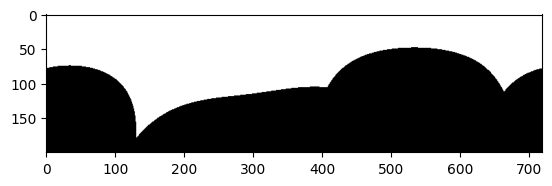

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [39]:
hs,Ss = np.meshgrid(np.linspace(-np.pi,np.pi,720),np.linspace(0,1,200))

Rs = to_R(Ss, hs)
Gs = to_G(Ss, hs)
Bs = to_B(Ss, hs)

gamut = np.minimum(Rs, np.minimum(Gs, Bs))

plt.imshow(np.sign(gamut), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.figure()

In [40]:
# r_lab = linear_srgb_to_oklab(np.array([1,0,0]))
# g_lab = linear_srgb_to_oklab(np.array([0,1,0]))
# b_lab = linear_srgb_to_oklab(np.array([0,0,1]))

r_lab = rec2020_to_oklab(np.array([1,0,0]))
g_lab = rec2020_to_oklab(np.array([0,1,0]))
b_lab = rec2020_to_oklab(np.array([0,0,1]))


r_h = np.arctan2(r_lab[2], r_lab[1])
g_h = np.arctan2(g_lab[2], g_lab[1])
b_h = np.arctan2(b_lab[2], b_lab[1])

print(r_h)
print(g_h)
print(b_h)


r_dir = 0.5*np.array([np.cos(b_h)+np.cos(g_h),np.sin(b_h)+np.sin(g_h)])
g_dir = 0.5*np.array([np.cos(b_h)+np.cos(r_h),np.sin(b_h)+np.sin(r_h)])
b_dir = 0.5*np.array([np.cos(r_h)+np.cos(g_h),np.sin(r_h)+np.sin(g_h)])

r_dir /= r_dir[0]**2 + r_dir[1]**2
g_dir /= g_dir[0]**2 + g_dir[1]**2
b_dir /= b_dir[0]**2 + b_dir[1]**2



# These are coefficients to quickly test which component goes below zero first.
# Used like this in compute_max_saturation:
# if (-1.88170328f * a - 0.80936493f * b > 1) # Red component goes below zero first

print(r_dir)
print(g_dir)
print(b_dir)

0.422033931064875
2.6634472082964327
-2.0057620652570822
[-1.36829327 -0.46690566]
[ 2.01082106 -2.03699421]
[0.06448067 2.29770138]


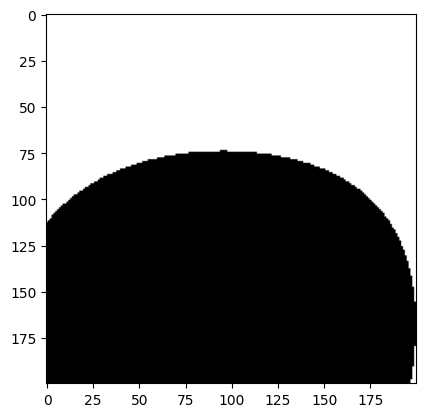

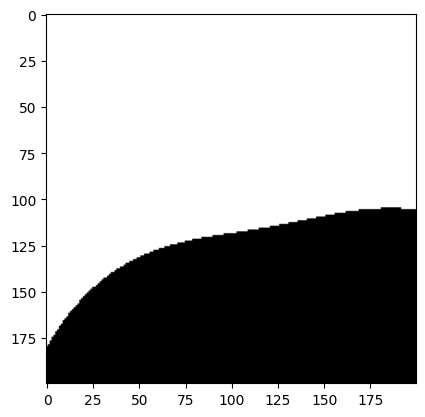

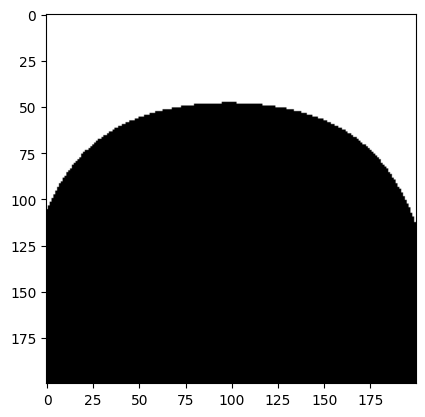

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [41]:
r_hs,r_Ss = np.meshgrid(np.linspace(g_h,2*np.pi + b_h,200),np.linspace(0,1,200))

r_Rs = to_R(r_Ss, r_hs)

plt.imshow(np.sign(r_Rs), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.figure()

g_hs,g_Ss = np.meshgrid(np.linspace(b_h,r_h,200),np.linspace(0,1,200))

g_Gs = to_G(g_Ss, g_hs)

plt.imshow(np.sign(g_Gs), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.figure()

b_hs,b_Ss = np.meshgrid(np.linspace(r_h,g_h,200),np.linspace(0,1,200))

b_Bs = to_B(b_Ss, b_hs)

plt.imshow(np.sign(b_Bs), cmap='gray', vmin=0, vmax=1)
plt.show()
plt.figure()


[1.19086277 1.76576728 0.59662641 0.75515197 0.56771245]
[ 0.73956515 -0.45954404  0.08285427  0.12541073 -0.14503204]
[ 1.35733652 -0.00915799 -1.1513021  -0.50559606  0.00692167]


<Figure size 640x480 with 0 Axes>

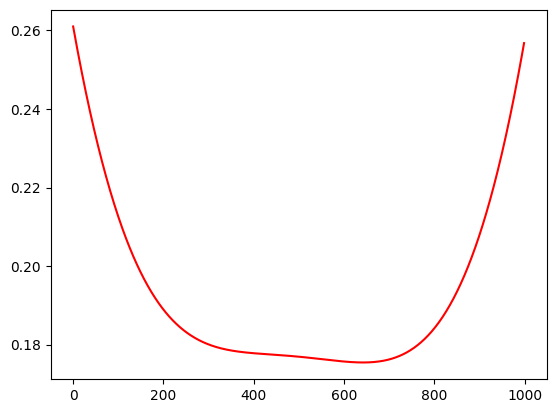

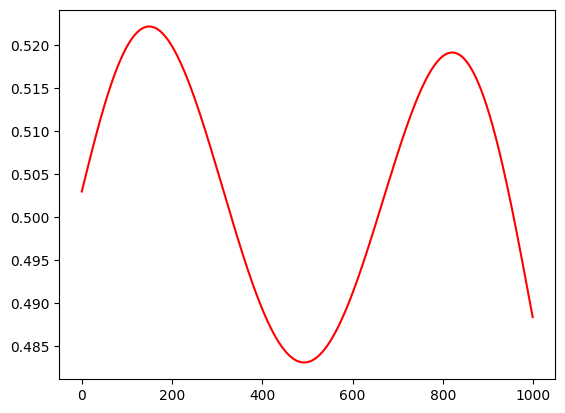

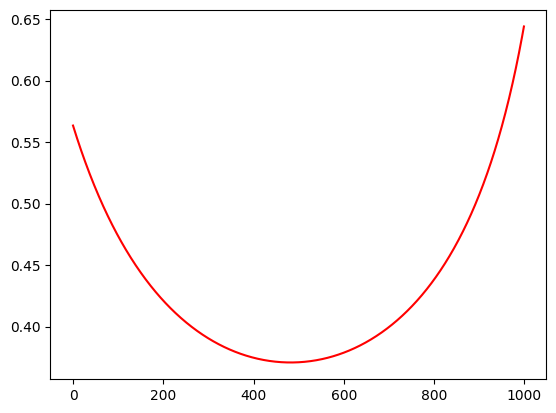

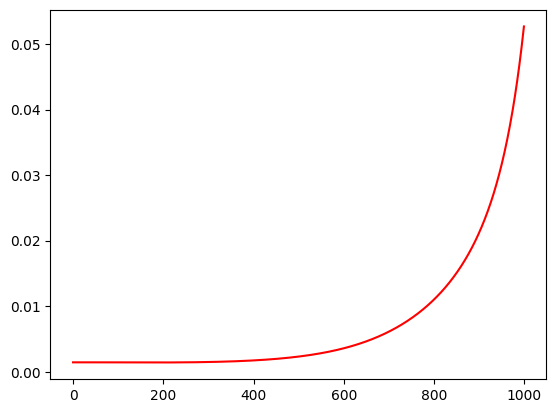

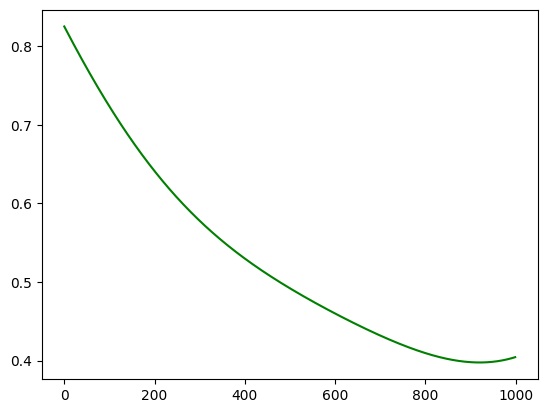

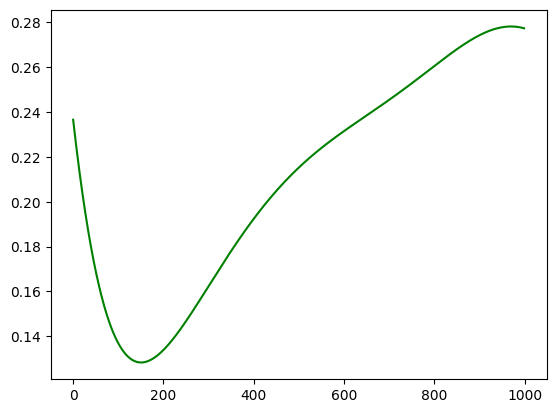

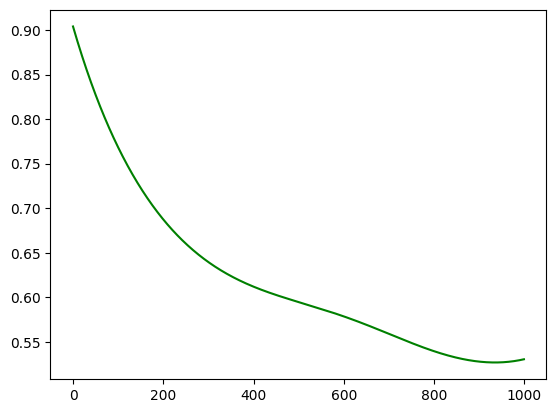

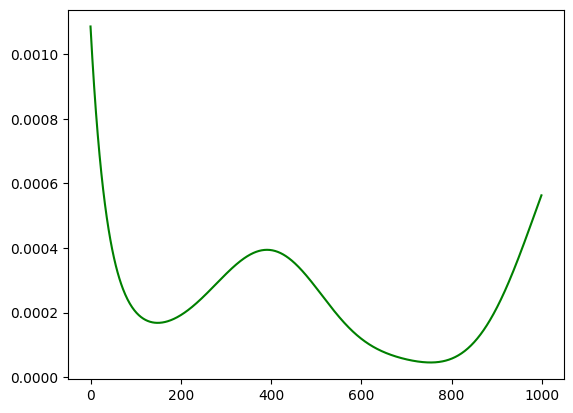

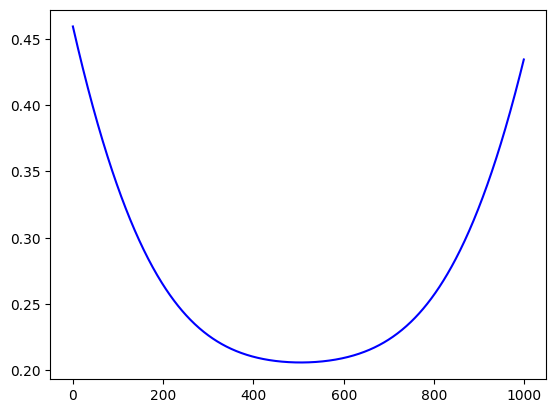

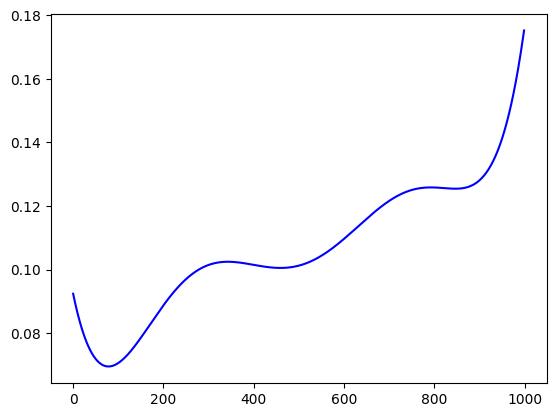

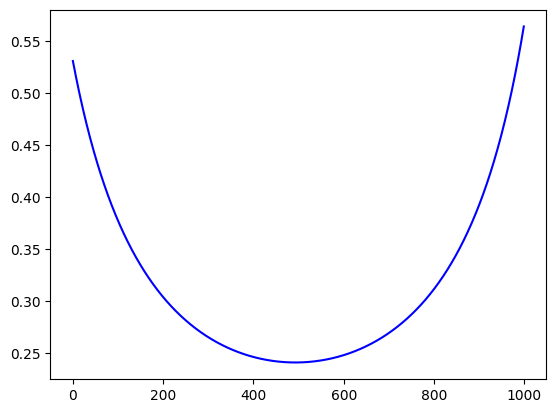

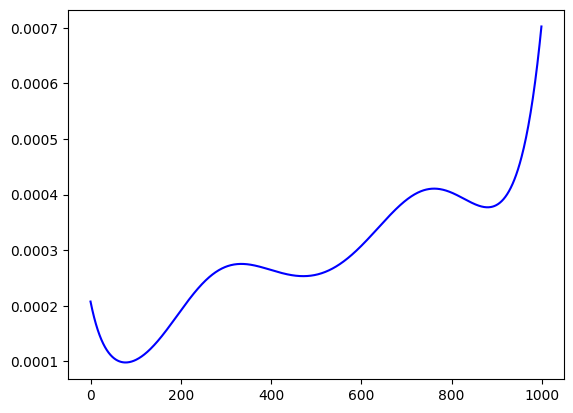

<Figure size 640x480 with 0 Axes>

In [42]:
# These are numerical fits to the edge of the chroma
# The resulting coefficient, x_R, x_G and x_B are used in compute_max_saturation, as values for k0

its = 1

h = np.linspace(g_h,2*np.pi + b_h,1000)
a = np.cos(h)
b = np.sin(h)

def e_R(x):
  S = x[0] + x[1]*a + x[2]*b + x[3]*a**2 + x[4]*a*b
  S = np.maximum(0, S)

  # optimize for solution that is easiest to solve with one step Haley's method
  f = to_R(S, h)
  f1 = to_R_dS(S, h)
  f2 = to_R_dS2(S, h)
  S_1 = S - f*f1/(f1**2 - f*f2/2)

  f_ = to_R(S_1, h)
  return np.average(f_**10) #+ f_[0]**2 + f_[-1]**2

x_R = scipy.optimize.minimize(e_R, np.array([1.19086277, 1.76576728, 0.59662641, 0.75515197, 0.56771245])).x

print(x_R)

S_R = x_R[0] + x_R[1]*a + x_R[2]*b + x_R[3]*a**2 + x_R[4]*a*b

plt.plot(S_R, 'r')
plt.figure()

plt.plot(to_R(S_R, h), 'r')
plt.figure()

S_R1 = S_R
for i in range(0,its):
  f = to_R(S_R1, h)
  f1 = to_R_dS(S_R1, h)
  f2 = to_R_dS2(S_R1, h)
  S_R1 = S_R1 - f*f1/(f1**2 - f*f2/(2))

  plt.plot(S_R1, 'r')

plt.figure()

plt.plot(to_R(S_R1, h), 'r')
plt.figure()

#####

h = np.linspace(b_h,r_h,1000)
a = np.cos(h)
b = np.sin(h)

def e_G(x):
  S = x[0] + x[1]*a + x[2]*b + x[3]*a**2 + x[4]*a*b
  S = np.maximum(0, S)

  # optimize for solution that is easiest to solve with one step Haley's method
  f = to_G(S, h)
  f1 = to_G_dS(S, h)
  f2 = to_G_dS2(S, h)
  S_1 = S - f*f1/(f1**2 - f*f2/2)

  f_ = to_G(S_1, h)
  return np.average(f_**10) #+ f_[0]**2 + f_[-1]**2

x_G = scipy.optimize.minimize(e_G, np.array([0.73956515, -0.45954404,  0.08285427,  0.12541073, -0.14503204])).x

print(x_G)

S_G = x_G[0] + x_G[1]*a + x_G[2]*b + x_G[3]*a**2 + x_G[4]*a*b

plt.plot(S_G, 'g')
plt.figure()

plt.plot(to_G(S_G, h), 'g')
plt.figure()

S_G1 = S_G
for i in range(0,its):
  f = to_G(S_G1, h)
  f1 = to_G_dS(S_G1, h)
  f2 = to_G_dS2(S_G1, h)
  S_G1 = S_G1 - f*f1/(f1**2 - f*f2/(2))

  plt.plot(S_G1, 'g')

plt.figure()

plt.plot(to_G(S_G1, h), 'g')
plt.figure()


#####

h = np.linspace(r_h,g_h,1000)
a = np.cos(h)
b = np.sin(h)

def e_B(x):
  S = x[0] + x[1]*a + x[2]*b + x[3]*a**2 + x[4]*a*b
  S = np.maximum(0, S)

  # optimize for solution that is easiest to solve with one step Haley's method
  f = to_B(S, h)
  f1 = to_B_dS(S, h)
  f2 = to_B_dS2(S, h)
  S_1 = S - f*f1/(f1**2 - f*f2/2)

  f_ = to_B(S_1, h)
  return np.average(f_**10) #+ f_[0]**2 + f_[-1]**2

x_B = scipy.optimize.minimize(e_B, np.array([1.35733652, -0.00915799, -1.1513021,  -0.50559606,  0.00692167])).x

print(x_B)

S_B = x_B[0] + x_B[1]*a + x_B[2]*b + x_B[3]*a**2 + x_B[4]*a*b

plt.plot(S_B, 'b')
plt.figure()

plt.plot(to_B(S_B, h), 'b')
plt.figure()

S_B1 = S_B
for i in range(0,its):
  f = to_B(S_B1, h)
  f1 = to_B_dS(S_B1, h)
  f2 = to_B_dS2(S_B1, h)
  S_B1 = S_B1 - f*f1/(f1**2 - f*f2/(2))

  plt.plot(S_B1, 'b')

plt.figure()

plt.plot(to_B(S_B1, h), 'b')
plt.figure()